<a href="https://colab.research.google.com/github/y-lims/DADS7202_Potato/blob/main/Potato_cls_vgg16_multi_v1_seed1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up

In [1]:
!ls -l /root/.keras/


total 4
-rw-r--r-- 1 root root 120 Aug  5 14:49 keras.json


In [2]:
!nvidia-smi

Mon Aug  5 14:49:39 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
# List all NVIDIA GPUs as available in this computer (or Colab's session)
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-12446553-afc4-aa63-abb1-554dc3c88721)


# 1. Prepare the environment

## Import Lib

In [4]:
import sys
print( f"Python {sys.version}\n" )

import numpy as np
print( f"NumPy {np.__version__}\n" )

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
print( f"Matplotlib {matplotlib.__version__}\n" )

import tensorflow as tf
print( f"TensorFlow {tf.__version__}" )
print( f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )

# Count the number of GPUs as detected by tensorflow
gpus = tf.config.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
  print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

from google.colab import drive
# from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras

import os
import sys
import numpy as np
import pandas as pd
import random as rn
import sklearn
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from tensorflow import keras
# from keras.preprocessing.image import ImageDataGenerator
from IPython.display import Image, display
import matplotlib.cm as cmp
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split

import os
import numpy as np
import tensorflow as tf

import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt



Python 3.10.12 (main, Mar 22 2024, 16:50:05) [GCC 11.4.0]

NumPy 1.25.2

Matplotlib 3.7.1

TensorFlow 2.15.0
tf.keras.backend.image_data_format() = channels_last
TensorFlow detected 1 GPU(s):
.... GPU No. 0: Name = /physical_device:GPU:0 , Type = GPU


## Set seed 🚧🚧🚧🚧🚧🚧🚧

In [5]:
# Set fixed seeding values for reproducability during experiments
# Skip this cell if random initialization (with varied results) is needed
np_random_seed = 1
tf_random_seed = 1
model_name = 'vgg16_multi'
version = 'v1'
seedno = 1
owner_name = 'l_model'


np.random.seed(np_random_seed)
tf.random.set_seed(tf_random_seed)

# 2. Load the pretrained model (only the feature extractor) 🚧🚧🚧🚧🚧🚧

In [6]:
# Load the ImageNet VGG-16 model, ***excluding*** the classifier
# For VGG-16, the default input_shape is 224x224x3
img_w,img_h = 224,224
vgg_extractor = tf.keras.applications.vgg16.VGG16(weights = "imagenet", include_top=False, input_shape = (img_w, img_h, 3))

vgg_extractor.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

# 3. Prepare our dataset

Mount Drive

In [7]:
drive.mount('/content/drive')

Mounted at /content/drive


Define Class mapping

In [8]:
folder_path = '/content/drive/My Drive/Final_Potato/train_data/archive/'

d = {}
for filename in os.listdir(folder_path):
  # print(filename)
  if filename != 'Healthy':
    d[filename] = 1
  else:
    d[filename] = 0

print(d)

# class_mapping = d
# class_mapping = {'Healthy': 0, 'Blackleg': 1, 'Black Scurf': 1, 'Pink Rot': 1, 'Common Scab': 1, 'Dry Rot': 1}

# class_mapping = {'Healthy': 0, 'Blackleg': 1, 'Black Scurf': 2, 'Pink Rot': 3, 'Common Scab': 4, 'Dry Rot': 5}

{'Blackleg': 1, 'Black Scurf': 1, 'Pink Rot': 1, 'Common Scab': 1, 'Dry Rot': 1, 'Healthy': 0, 'All': 1}


## Load Train set

==== Healthy ====
Shape of x (Healthy): (305, 224, 224, 3)
Shape of y (Healthy): (305,)
latest index :  304


array([[[ 62,  56,  32],
        [ 63,  57,  33],
        [ 66,  60,  36],
        ...,
        [ 88,  70,  48],
        [ 86,  68,  46],
        [ 85,  67,  45]],

       [[ 66,  60,  36],
        [ 67,  61,  37],
        [ 69,  63,  39],
        ...,
        [ 88,  70,  48],
        [ 87,  69,  47],
        [ 86,  68,  46]],

       [[ 70,  64,  40],
        [ 71,  65,  41],
        [ 72,  66,  42],
        ...,
        [ 89,  71,  49],
        [ 88,  70,  48],
        [ 87,  69,  47]],

       ...,

       [[ 89,  63,  46],
        [ 90,  64,  47],
        [ 92,  66,  49],
        ...,
        [127, 101,  76],
        [126, 100,  75],
        [125,  99,  74]],

       [[ 88,  62,  45],
        [ 89,  63,  46],
        [ 91,  65,  48],
        ...,
        [126, 100,  75],
        [125,  99,  74],
        [124,  98,  73]],

       [[ 88,  62,  45],
        [ 89,  63,  46],
        [ 91,  65,  48],
        ...,
        [126, 100,  75],
        [124,  98,  73],
        [124,  98,  73]]], dtype=uint8)
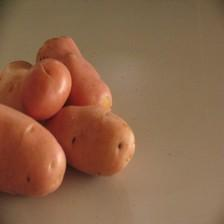

==== Blackleg ====
Shape of x (Blackleg): (60, 224, 224, 3)
Shape of y (Blackleg): (60,)
latest index :  364


array([[[230, 237, 243],
        [230, 237, 243],
        [231, 238, 244],
        ...,
        [220, 225, 231],
        [219, 224, 230],
        [219, 224, 230]],

       [[230, 237, 243],
        [230, 237, 243],
        [231, 238, 244],
        ...,
        [219, 224, 230],
        [219, 224, 230],
        [220, 225, 231]],

       [[231, 238, 244],
        [231, 238, 244],
        [232, 239, 245],
        ...,
        [218, 223, 229],
        [219, 224, 230],
        [220, 225, 231]],

       ...,

       [[235, 240, 244],
        [235, 240, 244],
        [236, 241, 245],
        ...,
        [216, 219, 226],
        [216, 219, 226],
        [216, 219, 226]],

       [[235, 240, 244],
        [235, 240, 244],
        [236, 241, 245],
        ...,
        [216, 219, 226],
        [216, 219, 226],
        [216, 219, 226]],

       [[235, 240, 244],
        [235, 240, 244],
        [236, 241, 245],
        ...,
        [215, 218, 225],
        [215, 218, 225],
        [215, 218, 225]]], dtype=uint8)
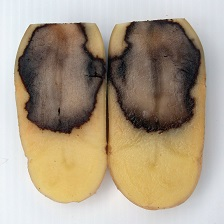


==== Black Scurf ====
Shape of x (Black Scurf): (58, 224, 224, 3)
Shape of y (Black Scurf): (58,)
latest index :  422


array([[[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       ...,

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]]], dtype=uint8)
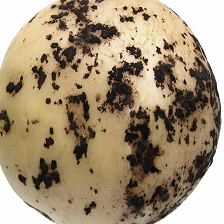


==== Pink Rot ====
Shape of x (Pink Rot): (57, 224, 224, 3)
Shape of y (Pink Rot): (57,)
latest index :  479


array([[[11, 11, 11],
        [12, 12, 12],
        [13, 13, 13],
        ...,
        [11, 11, 11],
        [13, 13, 13],
        [12, 12, 12]],

       [[11, 11, 11],
        [12, 12, 12],
        [13, 13, 13],
        ...,
        [11, 11, 11],
        [13, 13, 13],
        [12, 12, 12]],

       [[11, 11, 11],
        [12, 12, 12],
        [13, 13, 13],
        ...,
        [11, 11, 11],
        [13, 13, 13],
        [12, 12, 12]],

       ...,

       [[14, 14, 14],
        [15, 15, 15],
        [15, 15, 15],
        ...,
        [13, 13, 13],
        [12, 12, 12],
        [13, 13, 13]],

       [[15, 15, 15],
        [16, 16, 16],
        [16, 16, 16],
        ...,
        [14, 14, 14],
        [13, 13, 13],
        [16, 16, 16]],

       [[15, 15, 15],
        [16, 16, 16],
        [16, 16, 16],
        ...,
        [14, 14, 14],
        [13, 13, 13],
        [16, 16, 16]]], dtype=uint8)
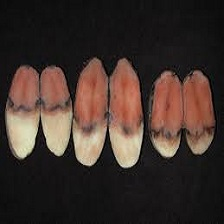


==== Common Scab ====
Shape of x (Common Scab): (62, 224, 224, 3)
Shape of y (Common Scab): (62,)
latest index :  541


array([[[ 92,  72,  47],
        [ 90,  70,  45],
        [ 89,  69,  44],
        ...,
        [136,  69,  50],
        [133,  66,  49],
        [130,  63,  46]],

       [[ 84,  64,  39],
        [ 82,  62,  37],
        [ 80,  60,  35],
        ...,
        [129,  67,  46],
        [128,  65,  47],
        [128,  65,  47]],

       [[ 81,  61,  36],
        [ 78,  58,  33],
        [ 77,  57,  33],
        ...,
        [127,  71,  48],
        [127,  70,  50],
        [129,  72,  52]],

       ...,

       [[ 46,  82, 130],
        [ 46,  84, 129],
        [ 46,  85, 128],
        ...,
        [193, 133,  63],
        [196, 136,  66],
        [203, 144,  74]],

       [[ 46,  84, 133],
        [ 44,  85, 131],
        [ 43,  84, 128],
        ...,
        [191, 130,  67],
        [186, 126,  63],
        [191, 133,  69]],

       [[ 43,  83, 134],
        [ 42,  82, 131],
        [ 41,  82, 126],
        ...,
        [191, 131,  69],
        [182, 122,  60],
        [183, 125,  62]]], dtype=uint8)
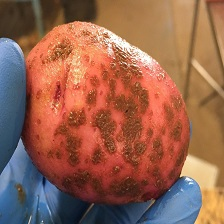


==== Dry Rot ====
Shape of x (Dry Rot): (60, 224, 224, 3)
Shape of y (Dry Rot): (60,)
latest index :  601


array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [240, 249, 248],
        [240, 249, 248],
        [240, 249, 248]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [240, 249, 248],
        [240, 249, 248],
        [240, 249, 248]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [240, 249, 248],
        [240, 249, 248],
        [241, 250, 249]]], dtype=uint8)
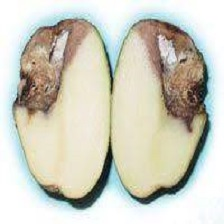

In [9]:
allowed_extensions = (".JPG", ".jpg", ".jpeg", ".JPEG", ".PNG", ".png")
# class_mapping = {'Healthy': 0, 'Blackleg': 1, 'Black Scurf': 1, 'Pink Rot': 1, 'Common Scab': 1, 'Dry Rot': 1}
class_mapping = {'Healthy': 0, 'Blackleg': 1, 'Black Scurf': 2, 'Pink Rot': 3, 'Common Scab': 4, 'Dry Rot': 5}

def process_dataset_nosplit(folder_path, class_name):

    print(f'==== {class_name} ====')
    x, y, z = [], [], []
    for filename in os.listdir(os.path.join(folder_path, class_name)):
        if filename.endswith(allowed_extensions):
            file_path = os.path.join(folder_path, class_name, filename)
            img = tf.keras.preprocessing.image.load_img(file_path, target_size=(224, 224))
            img_array = tf.keras.preprocessing.image.img_to_array(img).astype(np.uint8)
            x.append(img_array)
            y.append(class_mapping[class_name])
            z.append([class_name, filename])


    x = np.array(x)
    y = np.array(y).reshape(-1,)
    print(f"Shape of x ({class_name}):", x.shape)
    print(f"Shape of y ({class_name}):", y.shape)
    return x, y, z

# ==========================================================================================

folder_path = '/content/drive/My Drive/Final_Potato/train_data/archive/'
x, y, z = process_dataset_nosplit(folder_path, 'Healthy')
x_combined, y_combined, z_combined = x, y, z
print('latest index : ', len(x_combined) - 1)
display(x[0])

check_ind = [len(x_combined) - 1]
check_class = ['Healthy']
for i in list(class_mapping.keys())[1:]:
    x, y, z = process_dataset_nosplit(folder_path, i)
    x_combined = np.concatenate((x_combined, x), axis=0)
    y_combined = np.concatenate((y_combined, y), axis=0)
    z_combined = np.concatenate((z_combined, z), axis=0)
    print('latest index : ', len(x_combined) - 1)
    display(x[0])
    print()
    check_ind.append(len(x_combined) - 1)
    check_class.append(i)

x_train, y_train = x_combined, y_combined


In [10]:
train_information_df = pd.DataFrame(z_combined, columns=['class', 'filename']).reset_index(drop=0)
display(train_information_df)
train_information_df.to_csv(f'/content/drive/My Drive/Final_Potato/l_model/img_read_seq.csv', index=False)

,index,class,filename
0,0,Healthy,freshPotato (503).jpg
1,1,Healthy,freshPotato (410).jpg
2,2,Healthy,freshPotato (17).jpg
3,3,Healthy,freshPotato (273).jpg
4,4,Healthy,freshPotato (316).jpg
...,...,...,...
597,597,Dry Rot,36.jpg
598,598,Dry Rot,7.jpg
599,599,Dry Rot,60.jpg
600,600,Dry Rot,9.jpg


Validate image in train set

Healthy


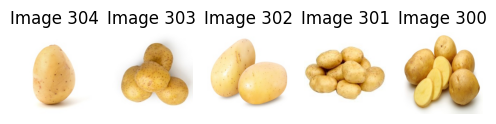

Blackleg


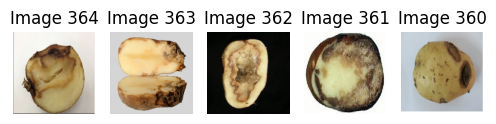

Black Scurf


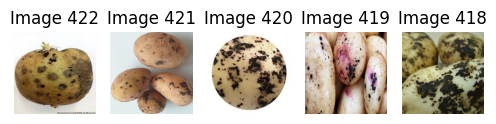

Pink Rot


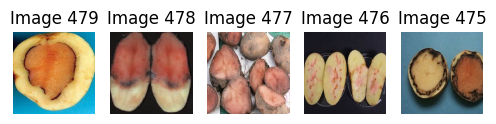

Common Scab


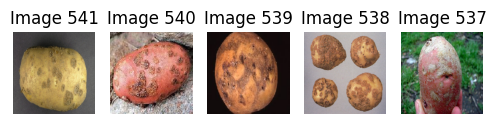

Dry Rot


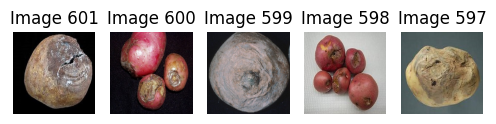

In [11]:
import matplotlib.pyplot as plt


for k,i in enumerate(check_ind):
    print(check_class[k])
    display_ind = list(range(i, i-5, -1))

    # Set up the subplots
    fig, axes = plt.subplots(1, 5, figsize=(5, 5))  # Adjust figsize for better display

    for j in range(5):
        # Display each image in the subplot
        axes[j].imshow(x_combined[display_ind[j]])
        axes[j].set_title(f"Image {display_ind[j]}")
        axes[j].axis('off')  # Hide the axes

    # Adjust layout
    plt.tight_layout()
    plt.show()


## Load Test set

==== Healthy ====
Shape of x (Healthy): (307, 224, 224, 3)
Shape of y (Healthy): (307,)
latest index :  306


array([[[220, 221, 216],
        [218, 219, 214],
        [207, 208, 203],
        ...,
        [200, 201, 195],
        [201, 202, 196],
        [201, 202, 196]],

       [[215, 216, 211],
        [211, 212, 207],
        [220, 221, 216],
        ...,
        [198, 199, 193],
        [201, 202, 196],
        [201, 202, 196]],

       [[219, 220, 215],
        [210, 211, 206],
        [216, 217, 212],
        ...,
        [202, 203, 197],
        [201, 202, 196],
        [202, 203, 197]],

       ...,

       [[203, 204, 198],
        [203, 204, 198],
        [203, 204, 198],
        ...,
        [195, 196, 190],
        [196, 197, 191],
        [197, 198, 192]],

       [[202, 203, 197],
        [204, 205, 199],
        [204, 205, 199],
        ...,
        [195, 196, 190],
        [195, 196, 190],
        [195, 196, 190]],

       [[201, 202, 196],
        [204, 205, 199],
        [204, 205, 199],
        ...,
        [195, 196, 190],
        [192, 193, 187],
        [194, 195, 189]]], dtype=uint8)
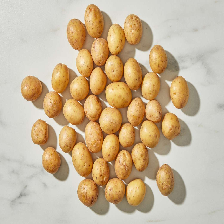

==== Blackleg ====
Shape of x (Blackleg): (60, 224, 224, 3)
Shape of y (Blackleg): (60,)
latest index :  366


array([[[182, 176, 180],
        [183, 177, 181],
        [183, 177, 181],
        ...,
        [165, 170, 166],
        [165, 170, 166],
        [166, 171, 167]],

       [[181, 175, 179],
        [184, 178, 182],
        [184, 178, 182],
        ...,
        [164, 169, 165],
        [164, 169, 165],
        [164, 169, 165]],

       [[180, 174, 178],
        [184, 178, 182],
        [184, 178, 182],
        ...,
        [165, 167, 164],
        [165, 167, 164],
        [165, 167, 164]],

       ...,

       [[194, 195, 213],
        [195, 196, 214],
        [195, 196, 214],
        ...,
        [190, 198, 211],
        [190, 198, 211],
        [194, 202, 215]],

       [[191, 192, 212],
        [192, 193, 213],
        [192, 193, 213],
        ...,
        [187, 195, 208],
        [187, 195, 208],
        [189, 197, 210]],

       [[199, 200, 221],
        [188, 189, 210],
        [188, 189, 210],
        ...,
        [189, 197, 210],
        [189, 197, 210],
        [188, 196, 209]]], dtype=uint8)
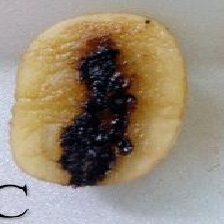


==== Black Scurf ====
Shape of x (Black Scurf): (66, 224, 224, 3)
Shape of y (Black Scurf): (66,)
latest index :  432


array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
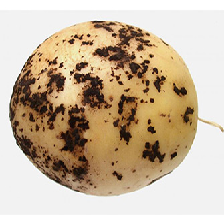


==== Pink Rot ====
Shape of x (Pink Rot): (51, 224, 224, 3)
Shape of y (Pink Rot): (51,)
latest index :  483


array([[[ 8,  8,  8],
        [ 6,  6,  6],
        [14, 14, 14],
        ...,
        [ 1,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1]],

       [[ 9,  9,  9],
        [ 8,  8,  8],
        [ 8,  8,  8],
        ...,
        [ 1,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1]],

       [[ 5,  5,  5],
        [ 6,  6,  6],
        [ 4,  4,  4],
        ...,
        [ 1,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1]],

       ...,

       [[ 3,  3,  3],
        [ 4,  4,  4],
        [ 4,  4,  4],
        ...,
        [ 5,  5,  5],
        [ 5,  5,  5],
        [ 5,  5,  5]],

       [[ 8,  8,  8],
        [ 7,  7,  7],
        [ 8,  8,  8],
        ...,
        [ 2,  2,  2],
        [ 2,  2,  2],
        [ 2,  2,  2]],

       [[66, 66, 66],
        [65, 65, 65],
        [66, 66, 66],
        ...,
        [65, 65, 65],
        [65, 65, 65],
        [65, 65, 65]]], dtype=uint8)
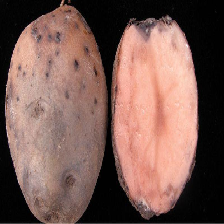


==== Common Scab ====
Shape of x (Common Scab): (60, 224, 224, 3)
Shape of y (Common Scab): (60,)
latest index :  543


array([[[15, 14, 10],
        [16, 15, 11],
        [17, 16, 12],
        ...,
        [15, 14, 10],
        [15, 14, 10],
        [15, 14, 10]],

       [[16, 15, 11],
        [16, 15, 11],
        [16, 15, 11],
        ...,
        [15, 14, 10],
        [15, 14, 10],
        [14, 13,  9]],

       [[17, 16, 12],
        [16, 15, 11],
        [15, 14, 10],
        ...,
        [15, 14, 10],
        [15, 14, 10],
        [16, 15, 11]],

       ...,

       [[20, 16, 13],
        [18, 14, 11],
        [16, 12,  9],
        ...,
        [15, 14, 10],
        [15, 14, 10],
        [15, 14, 10]],

       [[18, 14, 11],
        [18, 14, 11],
        [18, 14, 11],
        ...,
        [13, 12,  8],
        [17, 16, 12],
        [19, 18, 14]],

       [[18, 14, 11],
        [17, 13, 10],
        [19, 15, 12],
        ...,
        [14, 13,  9],
        [14, 13,  9],
        [15, 14, 10]]], dtype=uint8)
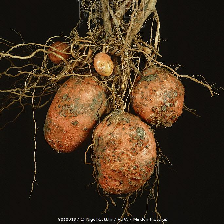


==== Dry Rot ====
Shape of x (Dry Rot): (51, 224, 224, 3)
Shape of y (Dry Rot): (51,)
latest index :  594


array([[[234, 236, 235],
        [234, 236, 235],
        [234, 236, 235],
        ...,
        [242, 244, 243],
        [242, 244, 243],
        [242, 244, 243]],

       [[234, 236, 235],
        [234, 236, 235],
        [234, 236, 235],
        ...,
        [242, 244, 243],
        [242, 244, 243],
        [242, 244, 243]],

       [[234, 236, 235],
        [234, 236, 235],
        [234, 236, 235],
        ...,
        [242, 244, 243],
        [242, 244, 243],
        [242, 244, 243]],

       ...,

       [[228, 230, 229],
        [228, 230, 229],
        [228, 230, 229],
        ...,
        [240, 242, 241],
        [240, 242, 241],
        [240, 242, 241]],

       [[228, 230, 229],
        [228, 230, 229],
        [228, 230, 229],
        ...,
        [240, 242, 241],
        [240, 242, 241],
        [240, 242, 241]],

       [[228, 230, 229],
        [228, 230, 229],
        [228, 230, 229],
        ...,
        [240, 242, 241],
        [240, 242, 241],
        [240, 242, 241]]], dtype=uint8)
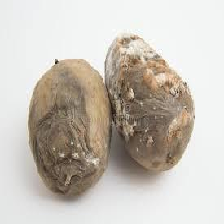

In [12]:
# ==========================================================================================

folder_path = '/content/drive/My Drive/Final_Potato/test_data/'
x, y, z = process_dataset_nosplit(folder_path, 'Healthy')
x_combined, y_combined, z_combined = x, y, z
print('latest index : ', len(x_combined) - 1)
display(x[0])

check_ind = [len(x_combined) - 1]
check_class = ['Healthy']
for i in list(class_mapping.keys())[1:]:
    x, y, z = process_dataset_nosplit(folder_path, i)
    x_combined = np.concatenate((x_combined, x), axis=0)
    y_combined = np.concatenate((y_combined, y), axis=0)
    z_combined = np.concatenate((z_combined, z), axis=0)
    print('latest index : ', len(x_combined) - 1)
    display(x[0])
    print()
    check_ind.append(len(x_combined) - 1)
    check_class.append(i)

x_test, y_test = x_combined, y_combined


In [13]:
test_information_df = pd.DataFrame(z_combined, columns=['class', 'filename']).reset_index(drop=0)
display(test_information_df)

,index,class,filename
0,0,Healthy,healthy (13).jpg
1,1,Healthy,healthy (85).jpg
2,2,Healthy,healthy (86).jpg
3,3,Healthy,healthy (87).jpg
4,4,Healthy,healthy (88).jpg
...,...,...,...
590,590,Dry Rot,DR45.jpg
591,591,Dry Rot,DR46.jpg
592,592,Dry Rot,DR47.jpg
593,593,Dry Rot,DR48.jpg


Train and test dataset

In [14]:
from sklearn.model_selection import train_test_split


# # Set a random seed for reproducibility
# split_random_seed = 42

# # Perform train-test split with stratification and random seed
# x_train, x_test, y_train, y_test = train_test_split(x_combined, y_combined, test_size=0.2, stratify=y_combined, random_state=split_random_seed)

print(f'Shape of x_train: {x_train.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of x_test: {x_test.shape}')
print(f'Shape of y_test: {y_test.shape}')


Shape of x_train: (602, 224, 224, 3)
Shape of y_train: (602,)
Shape of x_test: (595, 224, 224, 3)
Shape of y_test: (595,)


Merge all dataset together

In [15]:
print('==== Full train set ====')
print(f'Shape of x_train: {x_train.shape}')
print(f'Shape of y_train: {y_train.shape}')
print()


print('==== Full test set ====')
print(f'Shape of x_test: {x_test.shape}')
print(f'Shape of y_test: {y_test.shape}')

print()
print('==== Total ====')
print("Total images : ",x_train.shape[0] + x_test.shape[0])

==== Full train set ====
Shape of x_train: (602, 224, 224, 3)
Shape of y_train: (602,)

==== Full test set ====
Shape of x_test: (595, 224, 224, 3)
Shape of y_test: (595,)

==== Total ====
Total images :  1197


In [16]:
# (x_train , y_train), (x_test , y_test) = tf.keras.datasets.cifar10.load_data()

# Inspect the dataset
print( f"x_train: type={type(x_train)} , dtype={x_train.dtype} , shape={x_train.shape} , min={x_train.min(axis=None)} , max={x_train.max(axis=None)}" )
print( f"y_train: type={type(y_train)} , dtype={y_train.dtype} , shape={y_train.shape} , min={min(y_train)} , max={max(y_train)}" )
print( f"x_test: type={type(x_test)} , dtype={x_test.dtype} , shape={x_test.shape} , min={x_test.min(axis=None)} , max={x_test.max(axis=None)}"  )
print( f"y_test: type={type(y_test)} , dtype={y_test.dtype} , shape={y_test.shape} , min={min(y_test)} , max={max(y_test)}" )

x_train: type=<class 'numpy.ndarray'> , dtype=uint8 , shape=(602, 224, 224, 3) , min=0 , max=255
y_train: type=<class 'numpy.ndarray'> , dtype=int64 , shape=(602,) , min=0 , max=5
x_test: type=<class 'numpy.ndarray'> , dtype=uint8 , shape=(595, 224, 224, 3) , min=0 , max=255
y_test: type=<class 'numpy.ndarray'> , dtype=int64 , shape=(595,) , min=0 , max=5


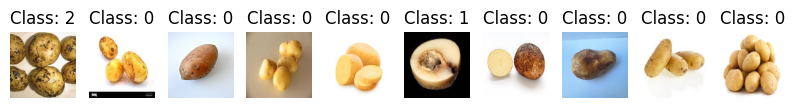

In [17]:
import random
import matplotlib.pyplot as plt

# Set the number of images to display
num_images = 10

# Randomly select indices
random_indices = random.sample(range(len(x_train)), num_images)

# Visualize the randomly selected images
plt.figure(figsize=(10, 10))
for i, idx in enumerate(random_indices):
    plt.subplot(1, num_images, i + 1)
    plt.imshow(x_train[idx].astype('uint8'))
    plt.title(f"Class: {y_train[idx]}")
    plt.axis("off")
plt.show()


# Data Prep for specific model 🚧🚧🚧🚧🚧🚧🚧🚧

In [18]:
# Preprocess arttoy dataset to match VGG-16's requirements
x_train_vgg = tf.keras.applications.vgg16.preprocess_input(x_train)
x_test_vgg = tf.keras.applications.vgg16.preprocess_input(x_test)

from sklearn.utils import shuffle
x_train_vgg_shuffle, y_train_shuffle = shuffle(x_train_vgg, y_train, random_state=42)

print( x_train_vgg.dtype, x_train_vgg.shape, np.min(x_train_vgg), np.max(x_train_vgg) )
print( x_test_vgg.dtype, x_test_vgg.shape, np.min(x_test_vgg), np.max(x_test_vgg) )

float32 (602, 224, 224, 3) -123.68 151.061
float32 (595, 224, 224, 3) -123.68 151.061


# Data Augmentation Layer

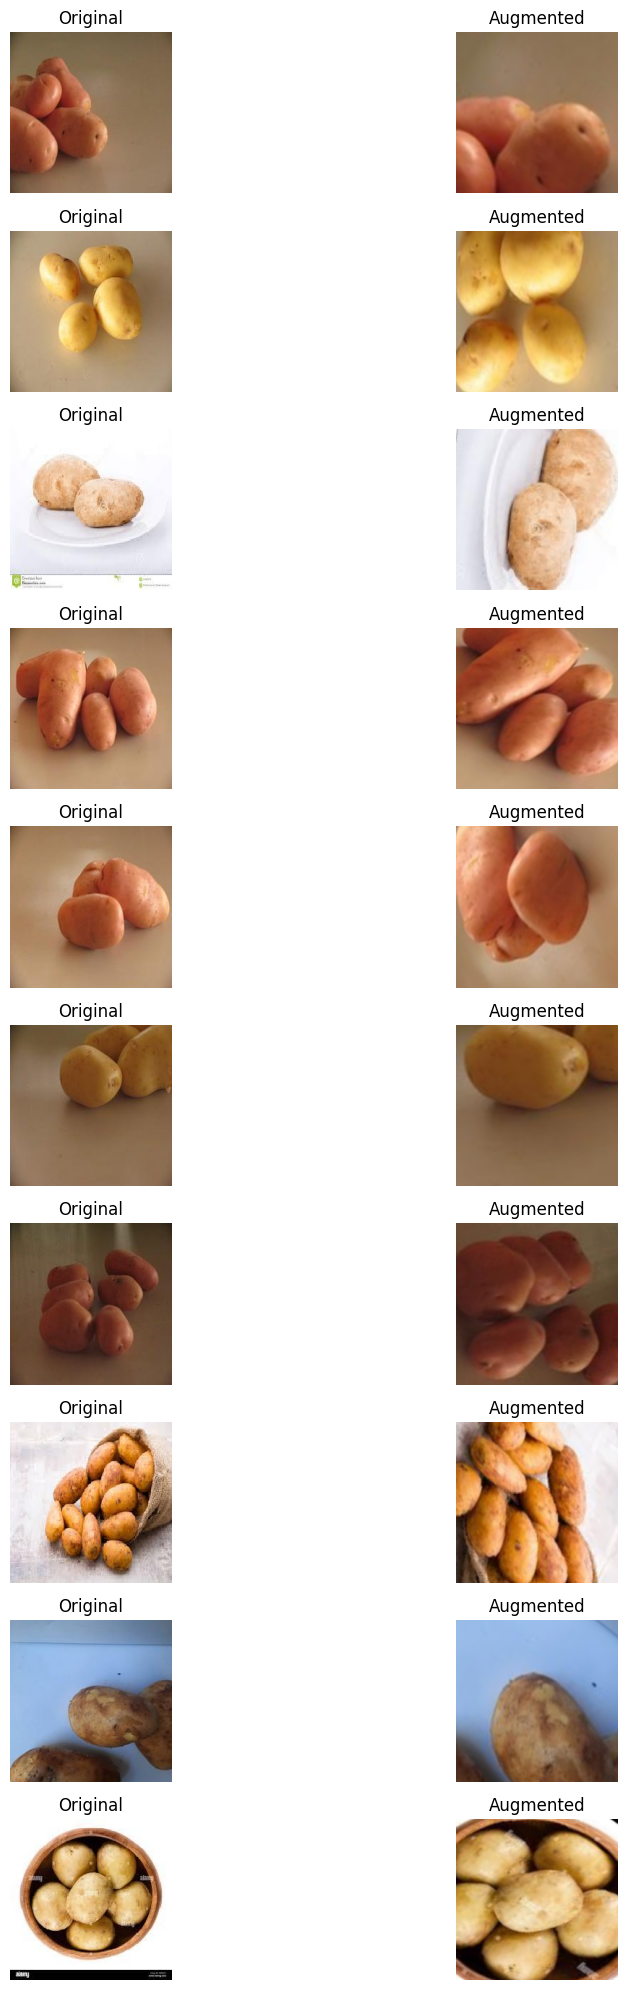

In [19]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Create data augmentation pipeline with additional transformations
data_augmentation = tf.keras.Sequential([
    # layers.Rescaling(1./255),
    # layers.RandomFlip("horizontal"),
    # layers.RandomFlip("vertical"),  # Additional flip for vertical flipping
    layers.RandomRotation(0.4),
    layers.RandomZoom(height_factor=(-0.2, -0.5), width_factor=(-0.2, -0.5)),  # Zoom in only
    # layers.RandomContrast(0.9),  # Adjust contrast randomly
    # layers.RandomCrop(height=180, width=180),  # Randomly crop to 180x180 from original size
    # layers.CenterCrop(height=150, width=150),  # Center crop to 150x150
])

# ===========================================

# Assume you have image data in x_train
# We will select some images from x_train to show examples
num_examples = 10 # Number of images to display
sample_images = x_train[:num_examples]

# Apply data augmentation to sample images
augmented_images = data_augmentation(sample_images)

# Display original and augmented images in pairs
plt.figure(figsize=(12, 2 * num_examples))
for i in range(num_examples):
    # Original image
    plt.subplot(num_examples, 2, 2 * i + 1)
    plt.imshow(sample_images[i].astype("uint8"))
    plt.axis("off")
    plt.title("Original")

    # Augmented image
    plt.subplot(num_examples, 2, 2 * i + 2)
    plt.imshow(augmented_images[i].numpy().astype("uint8"))
    plt.axis("off")
    plt.title("Augmented")

plt.tight_layout()
plt.show()


# 4. Prepare for transfer learning and finetuning

1. Add the new classification head
2. Decide whether to freeze or unfreeze any pretrained layers

## 4.1 Access and freeze layer(s) in Keras's model 🚧🚧🚧🚧🚧🚧

### Freeze Layer

In [20]:
# All Layer

vgg_extractor.trainable = False
# Use 'enumerate' to iterate over layers
for i, layer in enumerate(vgg_extractor.layers):
    print( f"Layer {i}: name = {layer.name} , trainable = {layer.trainable}" )

Layer 0: name = input_1 , trainable = False
Layer 1: name = block1_conv1 , trainable = False
Layer 2: name = block1_conv2 , trainable = False
Layer 3: name = block1_pool , trainable = False
Layer 4: name = block2_conv1 , trainable = False
Layer 5: name = block2_conv2 , trainable = False
Layer 6: name = block2_pool , trainable = False
Layer 7: name = block3_conv1 , trainable = False
Layer 8: name = block3_conv2 , trainable = False
Layer 9: name = block3_conv3 , trainable = False
Layer 10: name = block3_pool , trainable = False
Layer 11: name = block4_conv1 , trainable = False
Layer 12: name = block4_conv2 , trainable = False
Layer 13: name = block4_conv3 , trainable = False
Layer 14: name = block4_pool , trainable = False
Layer 15: name = block5_conv1 , trainable = False
Layer 16: name = block5_conv2 , trainable = False
Layer 17: name = block5_conv3 , trainable = False
Layer 18: name = block5_pool , trainable = False


In [21]:
# Selective Freeze
# Access a layer by its 0-based index
# a = vgg_extractor.layers[3]
# print( f"Layer {a}: name = {a.name} , trainable = {a.trainable}" )

# Access a layer by its name
b = vgg_extractor.get_layer('block5_conv1')
b.trainable = True       # freeze this layer
print( f"Layer {b}: name = {b.name} , trainable = {b.trainable}" )

b = vgg_extractor.get_layer('block5_conv2')
b.trainable = True       # freeze this layer
print( f"Layer {b}: name = {b.name} , trainable = {b.trainable}" )

b = vgg_extractor.get_layer('block5_conv3')
b.trainable = True       # freeze this layer
print( f"Layer {b}: name = {b.name} , trainable = {b.trainable}" )


Layer <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7c87a5712a40>: name = block5_conv1 , trainable = True
Layer <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7c87a5711870>: name = block5_conv2 , trainable = True
Layer <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7c87a5713fd0>: name = block5_conv3 , trainable = True


In [22]:
# Iterate over all layers in the model
for i,layer in enumerate(vgg_extractor.layers):
    print( f"Layer {i}: name = {layer.name} , trainable = {layer.trainable}" )

Layer 0: name = input_1 , trainable = False
Layer 1: name = block1_conv1 , trainable = False
Layer 2: name = block1_conv2 , trainable = False
Layer 3: name = block1_pool , trainable = False
Layer 4: name = block2_conv1 , trainable = False
Layer 5: name = block2_conv2 , trainable = False
Layer 6: name = block2_pool , trainable = False
Layer 7: name = block3_conv1 , trainable = False
Layer 8: name = block3_conv2 , trainable = False
Layer 9: name = block3_conv3 , trainable = False
Layer 10: name = block3_pool , trainable = False
Layer 11: name = block4_conv1 , trainable = False
Layer 12: name = block4_conv2 , trainable = False
Layer 13: name = block4_conv3 , trainable = False
Layer 14: name = block4_pool , trainable = False
Layer 15: name = block5_conv1 , trainable = True
Layer 16: name = block5_conv2 , trainable = True
Layer 17: name = block5_conv3 , trainable = True
Layer 18: name = block5_pool , trainable = False


In [35]:
# Create the main model
inputs = tf.keras.Input(shape=(img_w, img_h, 3))
x = data_augmentation(inputs)
x = vgg_extractor(x, training=False)  # Use the extractor with the augmented data


# FC layer
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
new_outputs = tf.keras.layers.Dense(6, activation="softmax")(x)  # output layer for 3 classes

model = tf.keras.models.Model(inputs=inputs, outputs=new_outputs)

# Print the model summary
# model.summary()
model.summary(expand_nested=True)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| random_rotation (RandomRo  (None, 224, 224, 3)       0        |
| tation)                                                       |
|                                                               |
| random_zoom (RandomZoom)   (None, 224, 224, 3)       0        |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| input_1 (InputLayer)       [(None, 224, 224, 3)]     0        |
|                                                          

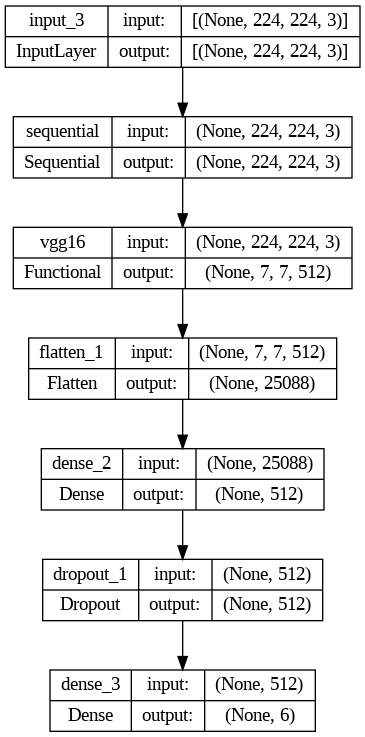

In [36]:
keras.utils.plot_model(model, show_shapes=True)


## 4.2 Add a new classification head

In [37]:
# x = vgg_extractor.output

# # Add our custom layer(s) to the end of the existing model
# x = tf.keras.layers.Flatten()(x)
# x = tf.keras.layers.Dense(512, activation="relu")(x)
# x = tf.keras.layers.Dropout(0.5)(x)
# new_outputs = tf.keras.layers.Dense(3, activation="softmax")(x) # output layer 10 class

# # Construct the main model
# model = tf.keras.models.Model(inputs=vgg_extractor.inputs, outputs=new_outputs)
# model.summary()

## XX 4.3 Data Augmentation XX

In [38]:
# train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#         #rescale=1. / 255,
#         #featurewise_center=True,
#         #featurewise_std_normalization=True,
#         #zca_whitening=False,
#         samplewise_center=True,
#         samplewise_std_normalization=True,
#         rotation_range=0,
#         width_shift_range=5.0,
#         height_shift_range=5.0,
#         zoom_range=0.2,
#         horizontal_flip=True,
#         # vertical_flip=True,
#         validation_split=0.3)
# train_datagen.fit(x_train_vgg)


In [39]:
# test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#         # rescale=1. / 255,
#         # featurewise_center=True,
#         # featurewise_std_normalization=True,
#         samplewise_center=True,
#         samplewise_std_normalization=True
#         )
# test_datagen.fit(x_test_vgg)

# 5. Train the model with transfer learning

No finetuning is done in this example as all pretrained layers are freezed and only newly added layers are trained.

In [40]:
model.compile( optimizer=tf.keras.optimizers.Adam(learning_rate=0.001) ,
                       loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                       metrics=['acc']
                     )

history = model.fit(x_train_vgg_shuffle, y_train_shuffle,
                    epochs=30,
                    batch_size=64,
                    verbose=2,
                    validation_split=0.2)


Epoch 1/30
8/8 - 5s - loss: 37.0034 - acc: 0.5135 - val_loss: 29.9986 - val_acc: 0.5537 - 5s/epoch - 629ms/step
Epoch 2/30
8/8 - 2s - loss: 10.0176 - acc: 0.6944 - val_loss: 16.3608 - val_acc: 0.6860 - 2s/epoch - 309ms/step
Epoch 3/30
8/8 - 3s - loss: 4.9966 - acc: 0.8046 - val_loss: 16.1879 - val_acc: 0.6281 - 3s/epoch - 316ms/step
Epoch 4/30
8/8 - 3s - loss: 3.3342 - acc: 0.8295 - val_loss: 10.1269 - val_acc: 0.6942 - 3s/epoch - 331ms/step
Epoch 5/30
8/8 - 3s - loss: 1.7253 - acc: 0.8316 - val_loss: 6.4825 - val_acc: 0.7273 - 3s/epoch - 328ms/step
Epoch 6/30
8/8 - 3s - loss: 1.0715 - acc: 0.8378 - val_loss: 6.3363 - val_acc: 0.6942 - 3s/epoch - 335ms/step
Epoch 7/30
8/8 - 3s - loss: 0.9105 - acc: 0.8462 - val_loss: 6.5167 - val_acc: 0.6942 - 3s/epoch - 334ms/step
Epoch 8/30
8/8 - 3s - loss: 0.7196 - acc: 0.8545 - val_loss: 5.1802 - val_acc: 0.7273 - 3s/epoch - 338ms/step
Epoch 9/30
8/8 - 3s - loss: 0.6415 - acc: 0.8690 - val_loss: 4.4821 - val_acc: 0.7025 - 3s/epoch - 333ms/step
Epoc

## Save model

In [41]:
# model.save(f'/content/drive/My Drive/Final_Potato/l_model/{model_name}_{version}_{seedno}_{np_random_seed}_{tf_random_seed}.h5')


In [42]:
#saving model
from keras.saving import save_model

model_path = f'/content/drive/My Drive/Final_Potato/{owner_name}/{model_name}_{version}_{seedno}_{np_random_seed}_{tf_random_seed}.keras'
save_model(model, model_path)

Load model

In [43]:
from tensorflow.keras.models import load_model

drive.mount('/content/drive')
model = load_model(model_path)
model.summary(expand_nested=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| random_rotation (RandomRo  (None, 224, 224, 3)       0        |
| tation)                                                       |
|                                                               |
| random_zoom (RandomZoom)   (None, 224, 224, 3)       0        |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| input_1 (InputLayer)       [(None, 224, 224, 3)]     0        |
|                                                          

# Save History

In [44]:

import pickle
history_path = f'/content/drive/My Drive/Final_Potato/{owner_name}/{model_name}_{version}_{seedno}_{np_random_seed}_{tf_random_seed}_history.pkl'

# บันทึกข้อมูลประวัติการฝึกอบรมลงในไฟล์
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f)

# สำหรับการโหลดข้อมูลประวัติการฝึกอบรมกลับมาใช้งาน
with open(history_path, 'rb') as f:
    loaded_history = pickle.load(f)

# ทดสอบการแสดงข้อมูล
print(loaded_history)

{'loss': [37.003421783447266, 10.017571449279785, 4.996635437011719, 3.334235668182373, 1.7253165245056152, 1.0715358257293701, 0.9104752540588379, 0.7195504307746887, 0.6414974331855774, 0.5093937516212463, 0.48940902948379517, 0.5968844890594482, 0.48274627327919006, 0.673457682132721, 0.5469629168510437, 0.45081794261932373, 0.4639597237110138, 0.4639124870300293, 0.3478415906429291, 0.3158079981803894, 0.34550803899765015, 0.36862826347351074, 0.30007636547088623, 0.4520156979560852, 0.4034857749938965, 0.3068205714225769, 0.35440176725387573, 0.408767968416214, 0.3684159517288208, 0.3894199728965759], 'acc': [0.5135135054588318, 0.6943867206573486, 0.8045738339424133, 0.8295218348503113, 0.8316008448600769, 0.837837815284729, 0.8461538553237915, 0.8544698357582092, 0.8690228462219238, 0.8565488457679749, 0.8648648858070374, 0.8731808662414551, 0.8627858757972717, 0.8440748453140259, 0.8357588648796082, 0.8898128867149353, 0.8981289267539978, 0.8690228462219238, 0.8752598762512207,

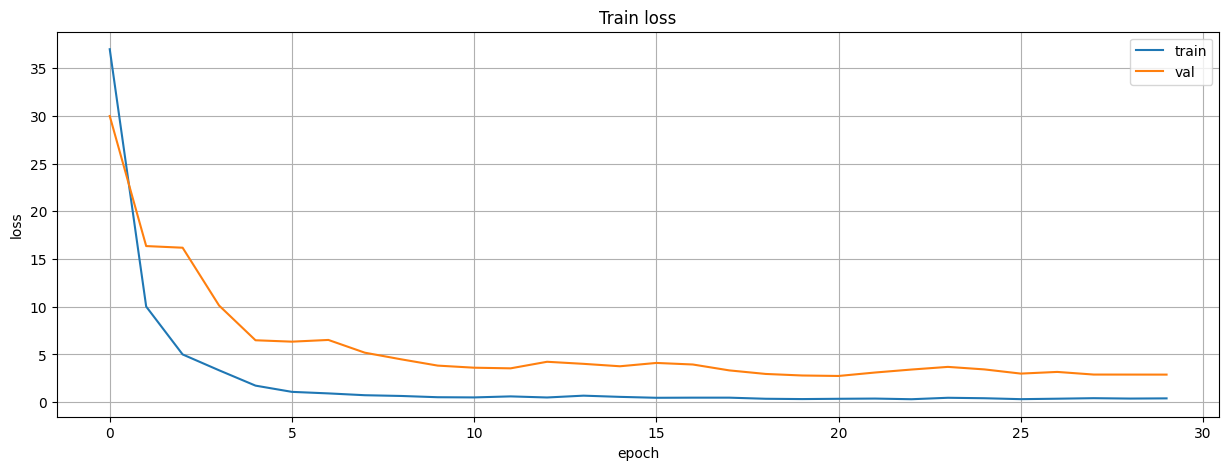

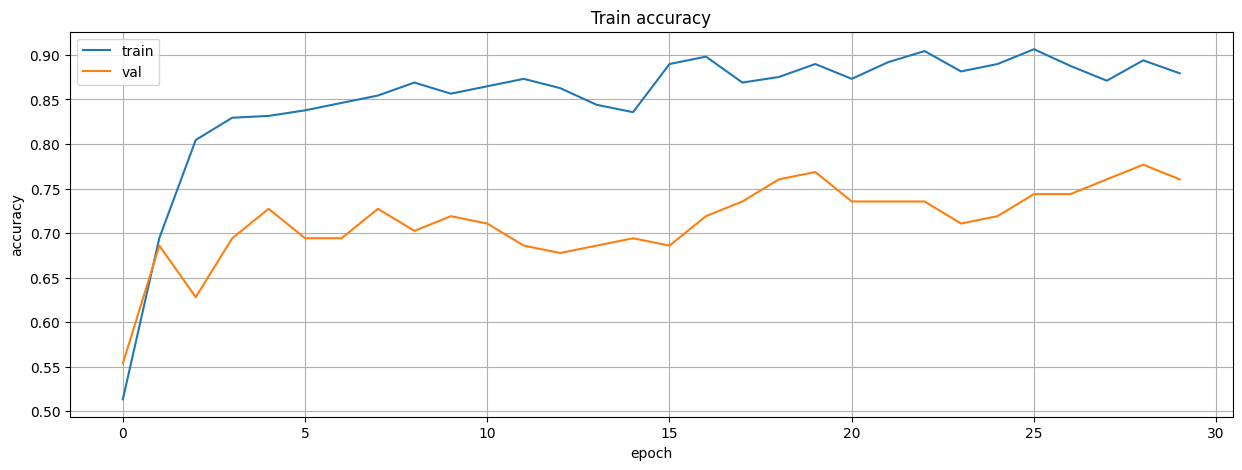

In [45]:
# Summarize history for loss
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid()
plt.show()

# Summarize history for accuracy
plt.figure(figsize=(15,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

# Evaluation 🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧

## Evaluate on Train set

1/1 [==============================] - 0s 22ms/step


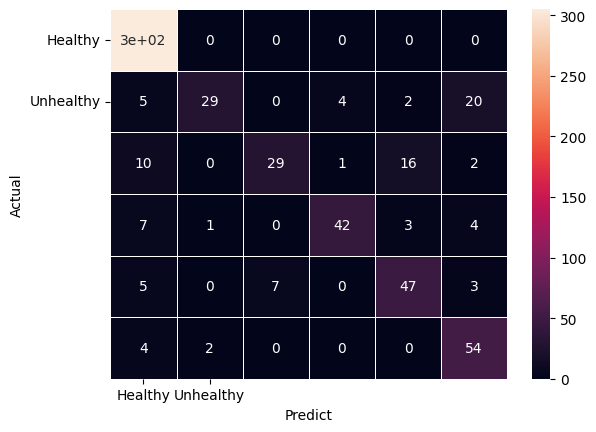

Accuracy: 0.8405
Recall: 0.7297
Precision: 0.8092
F1 Score: 0.7475
Indices of incorrect predictions: [305, 307, 308, 310, 311, 313, 317, 318, 319, 320, 322, 325, 330, 331, 332, 333, 337, 338, 339, 340, 341, 343, 345, 347, 349, 350, 356, 357, 359, 360, 361, 367, 369, 371, 375, 377, 378, 379, 381, 384, 385, 386, 387, 388, 390, 391, 392, 393, 395, 396, 398, 404, 405, 406, 408, 409, 411, 414, 417, 421, 434, 441, 444, 448, 453, 455, 459, 462, 463, 464, 466, 468, 472, 475, 476, 484, 487, 492, 496, 497, 498, 505, 506, 516, 521, 525, 527, 535, 536, 540, 544, 560, 561, 570, 585, 596]


In [46]:
# Assuming class_mapping is defined somewhere above
# label = [k for k, v in class_mapping.items()]
label = ['Healthy', 'Unhealthy']
y_pred = []
for i in range(len(x_train_vgg)):
    x_input = x_train_vgg[i][np.newaxis, ...]
    y_pred.append(np.argmax(model.predict(x_input)))

cm = confusion_matrix(y_train, y_pred)

# Plotting the confusion matrix
ax = sns.heatmap(cm, annot=True, xticklabels=label, yticklabels=label, linewidths=.5)
ax.set(xlabel='Predict', ylabel='Actual')
plt.show()

# Calculating and printing accuracy, recall, precision, and f1-score
accuracy = accuracy_score(y_train, y_pred)
recall = recall_score(y_train, y_pred, average='macro')  # Change 'macro' to 'micro' or 'weighted' as needed
precision = precision_score(y_train, y_pred, average='macro')  # Change 'macro' to 'micro' or 'weighted' as needed
f1 = f1_score(y_train, y_pred, average='macro')  # Change 'macro' to 'micro' or 'weighted' as needed

print(f'Accuracy: {accuracy:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Precision: {precision:.4f}')
print(f'F1 Score: {f1:.4f}')

# Extracting indices of wrong predictions
train_incorrect_indices = [i for i, (pred, actual) in enumerate(zip(y_pred, y_train)) if pred != actual]
print("Indices of incorrect predictions:", train_incorrect_indices)




In [47]:
train_information_df_write = train_information_df[train_information_df['index'].isin(train_incorrect_indices)]
train_information_df_write.to_csv(f'/content/drive/My Drive/Final_Potato/l_model/{model_name}_{version}_{seedno}_{np_random_seed}_{tf_random_seed}_train_incorrect.csv', index=False)

In [48]:
# Evaluate the trained model on the test set
results = model.evaluate(x_train_vgg, y_train, batch_size=128)
print( f"{model.metrics_names}: {results}" )

5/5 [==============================] - 40s 4s/step - loss: 1.2897 - acc: 0.8405
['loss', 'acc']: [1.2896720170974731, 0.840531587600708]


## Evaluate on Test set

In [ ]:
# Assuming class_mapping is defined somewhere above
# label = [k for k, v in class_mapping.items()]
# label = ['Healthy', 'Unhealthy']
y_pred = []
for i in range(len(x_test_vgg)):
    x_input = x_test_vgg[i][np.newaxis, ...]
    y_pred.append(np.argmax(model.predict(x_input)))

cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
ax = sns.heatmap(cm, annot=True, xticklabels=label, yticklabels=label, linewidths=.5)
ax.set(xlabel='Predict', ylabel='Actual')
plt.show()

# Calculating and printing accuracy, recall, precision, and f1-score
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro')  # Change 'macro' to 'micro' or 'weighted' as needed
precision = precision_score(y_test, y_pred, average='macro')  # Change 'macro' to 'micro' or 'weighted' as needed
f1 = f1_score(y_test, y_pred, average='macro')  # Change 'macro' to 'micro' or 'weighted' as needed

print(f'Accuracy: {accuracy:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Precision: {precision:.4f}')
print(f'F1 Score: {f1:.4f}')

# Extracting indices of wrong predictions
test_incorrect_indices = [i for i, (pred, actual) in enumerate(zip(y_pred, y_test)) if pred != actual]
print("Indices of incorrect predictions:", test_incorrect_indices)


1/1 [==============================] - 0s 18ms/step


In [ ]:
# Evaluate the trained model on the test set
results = model.evaluate(x_test_vgg, y_test, batch_size=128)
print( f"{model.metrics_names}: {results}" )

# 7. Inference

In [ ]:
# (Optional) Codes for coloring frames of the predicted images
plt.rcParams["axes.linewidth"] = 5

def color_frame( ax, y_true, y_pred ):
  # Green frame means correct prediction. Red frame means incorrect prediction.
  color = 'blue' if (y_true == y_pred) else 'red'
  ax.spines['bottom'].set_color(color)
  ax.spines['top'].set_color(color)
  ax.spines['right'].set_color(color)
  ax.spines['left'].set_color(color)

In [ ]:
# Test using the model on many images

# Get a batch of samples
n = 20
samples = x_test_vgg[:n]
print(f'{samples.shape=}')

# Predict a batch of samples
y_pred = model.predict(samples)

# Interpret the results
for i in range(n):
  plt.figure(figsize=(3,3), dpi=90)
  ax = plt.gca()
  plt.imshow( x_test[i] )
  # plt.title( f"x_test[{i}]: true={y_test[i][0]}({cifar10_labels[y_test[i][0]]}) , pred={np.argmax(y_pred[i])}({cifar10_labels[np.argmax(y_pred[i])]})" )
  color_frame(ax, y_test[i], np.argmax(y_pred[i]))
  plt.show()

# Grad-CAM

In [ ]:
# model.summary(expand_nested=True)

In [ ]:
# img_size = (224, 224)
# preprocess_input = keras.applications.vgg16.preprocess_input
# last_conv_layer_name = "vgg16"

In [ ]:
# def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
#     grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
#     with tf.GradientTape() as tape:
#           last_conv_layer_output, preds = grad_model(img_array)
#           if pred_index is None:
#               pred_index = tf.argmax(preds[0])
#           class_channel = preds[:, pred_index]
#     grads = tape.gradient(class_channel, last_conv_layer_output)
#     pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
#     last_conv_layer_output = last_conv_layer_output[0]
#     heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
#     heatmap = tf.squeeze(heatmap)
#     heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
#     return heatmap.numpy()

# def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.8):
#       img = img_path

#       # Rescale heatmap to a range 0-255
#       heatmap = np.uint8(255 * heatmap)

#       # Use jet colormap to colorize heatmap
#       jet = cmp.get_cmap("jet")

#       # Use RGB values of the colormap
#       jet_colors = jet(np.arange(256))[:, :3]
#       jet_heatmap = jet_colors[heatmap]

#       # Create an image with RGB colorized heatmap
#       jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
#       jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
#       jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

#       # Superimpose the heatmap on original image
#       superimposed_img = jet_heatmap * alpha + img
#       superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

#       # Save the superimposed image
#       superimposed_img.save(cam_path)

#       # Display Grad CAM
#       display(Image(cam_path))

# for i in range(25):
#   c= np.random.randint(0,x_test.shape[0])
#   img_path = x_test[c]
#   img_array = preprocess_input(img_path)
#   model.layers[-1].activation = None
#   preds = model.predict(img_array.reshape(-1,224,224,3))
#   print(f"Predicted: {label[np.argmax(preds)]} | Actual: {label[y_test[c]]} ")
#   heatmap = make_gradcam_heatmap(img_array.reshape(1,224,224,3), model, last_conv_layer_name)
#   save_and_display_gradcam(img_path, heatmap)


In [ ]:
# import numpy as np
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras.preprocessing import image
# import matplotlib.pyplot as plt
# from IPython.display import Image, display

# # ฟังก์ชันสำหรับสร้าง Grad-CAM heatmap
# # ฟังก์ชันสำหรับสร้าง Grad-CAM heatmap
# def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
#     # Get the input layer and the specific convolutional layer
#     vgg16_model = model.get_layer('vgg16') # Access the nested 'vgg16' model
#     last_conv_layer = vgg16_model.get_layer(last_conv_layer_name) # Access the layer through the nested model

#     # Create a model that maps the input image to the activations of the last conv layer
#     grad_model = tf.keras.models.Model(
#         [model.inputs],
#         [last_conv_layer.output, model.output]
#     )

#     with tf.GradientTape() as tape:
#         last_conv_layer_output, preds = grad_model(img_array)
#         if pred_index is None:
#             pred_index = tf.argmax(preds[0])
#         class_channel = preds[:, pred_index]

#     grads = tape.gradient(class_channel, last_conv_layer_output)
#     pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
#     last_conv_layer_output = last_conv_layer_output[0]
#     heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
#     heatmap = tf.squeeze(heatmap)
#     heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
#     return heatmap.numpy()

# # ฟังก์ชันสำหรับแสดงภาพพร้อม Grad-CAM heatmap
# def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
#     img = image.load_img(img_path)
#     img = image.img_to_array(img)

#     # Rescale heatmap to a range 0-255
#     heatmap = np.uint8(255 * heatmap)

#     # Use jet colormap to colorize heatmap
#     jet = plt.cm.get_cmap("jet")

#     # Use RGB values of the colormap
#     jet_colors = jet(np.arange(256))[:, :3]
#     jet_heatmap = jet_colors[heatmap]

#     # Create an image with RGB colorized heatmap
#     jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
#     jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
#     jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

#     # Superimpose the heatmap on original image
#     superimposed_img = jet_heatmap * alpha + img
#     superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

#     # Save the superimposed image
#     superimposed_img.save(cam_path)

#     # Display Grad CAM
#     display(Image(cam_path))

# # แสดง Grad-CAM heatmap สำหรับภาพที่เลือก
# def display_gradcam_for_images(model, x_test, y_test, label, n_images=5):
#     for i in range(n_images):
#         c = np.random.randint(0, x_test.shape[0])
#         img_path = x_test[c]
#         img_array = preprocess_input(img_path)
#         img_array = np.expand_dims(img_array, axis=0)

#         preds = model.predict(img_array)
#         print(f"Predicted: {label[np.argmax(preds)]} | Actual: {label[y_test[c]]} ")

#         heatmap = make_gradcam_heatmap(img_array, model, 'block5_conv3')
#         save_and_display_gradcam(img_path, heatmap, cam_path=f"cam_{i}.jpg")

# # เรียกใช้งานฟังก์ชัน
# display_gradcam_for_images(model, x_test, y_test, label)


In [ ]:
# # ฟังก์ชันสำหรับสร้าง Grad-CAM heatmap
# def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
#     # Get the input layer and the specific convolutional layer
#     vgg16_model = model.get_layer('vgg16') # Access the nested 'vgg16' model
#     last_conv_layer = vgg16_model.get_layer(last_conv_layer_name) # Access the layer through the nested model

#     # Create a model that maps the input image to the activations of the last conv layer
#     grad_model = tf.keras.models.Model(
#         [model.inputs],
#         [last_conv_layer.output, model.output]
#     )

#     with tf.GradientTape() as tape:
#         last_conv_layer_output, preds = grad_model(img_array)
#         if pred_index is None:
#             pred_index = tf.argmax(preds[0])
#         class_channel = preds[:, pred_index]

#     grads = tape.gradient(class_channel, last_conv_layer_output)
#     pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
#     last_conv_layer_output = last_conv_layer_output[0]
#     heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
#     heatmap = tf.squeeze(heatmap)
#     heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
#     return heatmap.numpy()